# Synthetic dataset generation

This file generates the synthetic dataset used in the other analyses and saves it in its folder. The main characteristic of this dataset is respecting demographic parity, but not equal opportunities, helping to isolate the study on the estimation and mitigation of the latter.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from fair_crowd.fairness_metrics import DemographicParity, EqualOpportunities, PredictiveParity

## Dataset Generation

To generate the dataset with near-zero demographic parity and high equal opportunities difference, we use a combinations of different workers' accuracies for sensitive and non-sensitive groups and different base rates. The main parameters are:

- sample size
- number of workers
- accuracy mean and variance for sensitive and non-sensitive group (uniform distribution)
- weight of the sensitive feature in the hidden feature
- variance of the normal noise in the hidden feature

In [3]:
#
# Parameters
#
np.random.seed(0)
n_samples = 5000
n_workers = 500
# x workers label the same y samples
workers_per_group = 10
samples_per_group = 10
# Sensitive samples are more likely to be positive
# To compensate and obtain a low demographic parity (and isolate the equal opportunities analysis)
# we make workers more accurate on non-sensitive samples
sensitive_accuracy = 0.6
non_sensitive_accuracy = 0.7
accuracy_variance = 0.05
# The hidden feature is a linear combination of the sensitive feature and normal noise
sensitive_weight = 1/3
noise_variance = 2/3

# Non-sensitive feature
x = np.random.normal(0, 1, n_samples)
# Sensitive feature
s = np.random.choice([0, 1], n_samples)
# Generate a noisy hidden feature, dependent on s, to influence the base rate
hidden_feature = sensitive_weight * s + np.random.normal(0, noise_variance, n_samples)
# Generate response as a logistic function
result = (1 / (1 + np.exp(-(x + hidden_feature))) > 0.5).astype(int)

# Generate workers' responses
worker_responses_array = np.full((n_samples, n_workers), np.nan)
for group in range(n_samples // samples_per_group):
  for group_worker in range(workers_per_group):
    worker = (group * workers_per_group + group_worker) % n_workers
    
    worker_accuracy_s1 = np.random.uniform(sensitive_accuracy - accuracy_variance, sensitive_accuracy + accuracy_variance)
    worker_accuracy_s0 = np.random.uniform(non_sensitive_accuracy - accuracy_variance, non_sensitive_accuracy + accuracy_variance)

    start = group * samples_per_group
    end = (group + 1) * samples_per_group
    samples_to_label = range(start, end)

    for sample in samples_to_label:
      worker_accuracy = worker_accuracy_s1 if s[sample] == 1 else worker_accuracy_s0
      # The worker's response is determined by their accuracy
      worker_responses_array[sample, worker] = result[sample] if np.random.uniform(0, 1) < worker_accuracy else 1 - result[sample]

mturk = pd.DataFrame(worker_responses_array)
x = pd.DataFrame(x, columns=['x'])
s = pd.DataFrame(s, columns=['s'])
result = pd.DataFrame(result, columns=['result'])
df = pd.concat([x, s, mturk, result], axis=1)

avg_samples = np.isfinite(mturk).sum(axis=0).mean()
avg_workers = np.isfinite(mturk).sum(axis=1).mean()
print(f'Every worker labels {avg_samples:.0f} samples on average')
print(f'Every sample is labeled by {avg_workers:.0f} workers on average')
df.head(15)

Every worker labels 100 samples on average
Every sample is labeled by 10 workers on average


,x,s,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,result
0,1.764052,1,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,0.400157,0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,0.978738,0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,2.240893,1,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,1.867558,0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5,-0.977278,0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6,0.950088,0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
7,-0.151357,0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
8,-0.103219,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
9,0.410599,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [4]:
pd.concat([x, s, result], axis=1).to_csv('./fair_crowd/datasets/Synthetic/dataset.csv')
mturk.to_csv('./fair_crowd/datasets/Synthetic/annotations.csv')

### Diagnostics

Scatterplot of the known and hidden features. Color: sensitive status

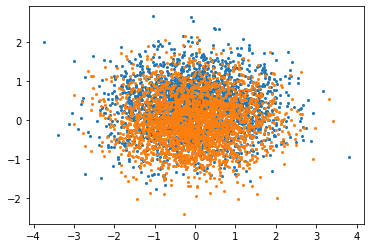

In [5]:
plt.scatter(x[s['s'] == 1], hidden_feature[s['s'] == 1], s=4)
plt.scatter(x[s['s'] == 0], hidden_feature[s['s'] == 0], s=4)
plt.show()

Scatterplot of the known and hidden features. Color: response

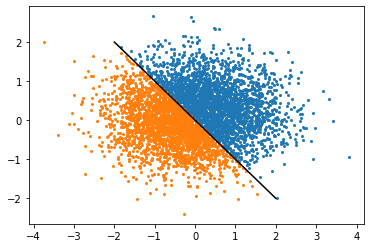

In [6]:
plt.plot([-2, 2], [2, -2], color='black')
plt.scatter(x[result['result'] == 1], hidden_feature[result['result'] == 1], s=4)
plt.scatter(x[result['result'] == 0], hidden_feature[result['result'] == 0], s=4)
plt.show()

Scatterplot of the known and hidden features. Color: majority voting predictions

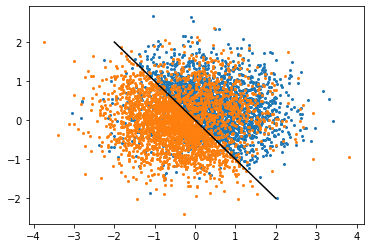

In [7]:
preds = np.array(mturk.mean(axis=1) > 0.5, dtype=np.int_)
plt.plot([-2, 2], [2, -2], color='black')
plt.scatter(x[preds == 1], hidden_feature[preds == 1], s=4)
plt.scatter(x[preds == 0], hidden_feature[preds == 0], s=4)
plt.show()

Scatterplot of the known and hidden features for sensitive samples. Color: majority voting predictions

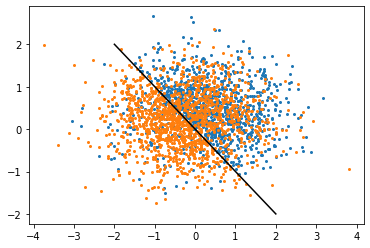

In [8]:
preds = np.array(mturk[s['s'] == 1].mean(axis=1) > 0.5, dtype=np.int_)
plt.plot([-2, 2], [2, -2], color='black')
plt.scatter(x[s['s'] == 1][preds == 1], hidden_feature[s['s'] == 1][preds == 1], s=4)
plt.scatter(x[s['s'] == 1][preds == 0], hidden_feature[s['s'] == 1][preds == 0], s=4)
plt.show()

Scatterplot of the known and hidden features for non-sensitive samples. Color: majority voting predictions

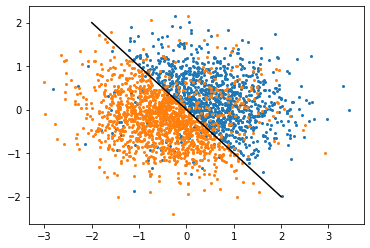

In [9]:
preds = np.array(mturk[s['s'] == 0].mean(axis=1) > 0.5, dtype=np.int_)
plt.plot([-2, 2], [2, -2], color='black')
plt.scatter(x[s['s'] == 0][preds == 1], hidden_feature[s['s'] == 0][preds == 1], s=4)
plt.scatter(x[s['s'] == 0][preds == 0], hidden_feature[s['s'] == 0][preds == 0], s=4)
plt.show()

- Accuracy of logistic regression using only the known feature
- Accuracy of workers' annotation
- Fairness metrics

In [10]:
model = LogisticRegression()
model.fit(df[['x']], df['result'])
accuracy = accuracy_score(df['result'], model.predict(df[['x']]))
print(f'Accuracy of logistic regression:\t {accuracy}')
accuracy = accuracy_score(df['result'], np.nanmean(mturk.values, axis=1) > 0.5)
print(f'Accuracy of majority voting:\t\t {accuracy}')

print()
predictions = mturk.mean(axis=1)
mv_eo = np.abs(EqualOpportunities().compute(predictions, df['s'].values, df['result'].values))
mv_dp = np.abs(DemographicParity().compute(predictions, df['s'].values, df['result'].values))
mv_pp = np.abs(PredictiveParity().compute(predictions, df['s'].values, df['result'].values))
print(f'Demographic parity of majority voting:\t {mv_dp}')
print(f'Equalized odds of majority voting:\t {mv_eo}')
print(f'Predictive parity of majority voting:\t {mv_pp}')

Accuracy of logistic regression:	 0.8118
Accuracy of majority voting:		 0.7976

Demographic parity of majority voting:	 0.0016491202638592717
Equalized odds of majority voting:	 0.24398672282417055
Predictive parity of majority voting:	 0.0861386369193865
